# Coding Controllers 2. State Estimation

This notebook will show to incorporate a state estimator into our basic control loop implementation.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import control
import pandas as pd

## Basic Control Implementation using Python Generators

### Code the Temperature Setpoint Function

We'll use the numpy linear interpolation function to create a data-driven version of the function determining the process setpoint.

Text(0.5, 1.0, 'Temperature Setpoint')

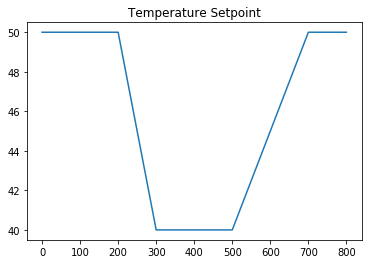

In [2]:
def Tsp(t):
    tp = [  0,  200,  300,  500,  700, 9999]
    Tp = [ 50,   50,   40,   40,   50,   50]
    return np.interp(t, tp, Tp)

t = np.linspace(0, 800, 801)
plt.plot(t, Tsp(t))
plt.title('Temperature Setpoint')

### Coding a Relay Function as a Python generator

More sophisticated control algorithms will retain information from one time step to the next. This retained information is the **state** of the controller.  We would like to keep the state of the controller outside of the main event loop. Python generators are ideal for this purpose.

The following cell creates a generator for relay control that switches between values of Qmin and Qmax depending on the difference between the T and Tsp.

The generator *yields* the value Q to whatever calls this generator.  It then suspends operation waiting for a message consisting of a list with values for Tsp and T. Upon getting that message, execution continues until the next yield is encountered.

In [5]:
def relay(Qmin, Qmax):
    Q = 0
    while True:
        Tsp, T = yield Q
        Q = Qmax if T < Tsp else Qmin

Here are a few lines that show how to create an instance of the generator, send it a message that causes it to execute the first yeld statement, then trigger further calculations.

In [9]:
controller = relay(0, 100)    # creates an instance of the generator
controller.send(None)         # causes the instance to advance to the first yeild statement

print("Q = ", controller.send([50, 22]))   # send a message with Tsp = 50, T = 20 and print the result
print("Q = ", controller.send([50, 40]))   # send a message with Tsp = 50, T = 40 and print the result
print("Q = ", controller.send([50, 60]))   # send a message with Tsp = 50, T = 60 and print the result

Q =  100
Q =  100
Q =  0


If you think of Python functions as **subroutines**, then Python generators might be called **coroutines**, i.e., routines that run side-by-side with your main function, with the yield statement and send functions providing a means of communication.

### Event Loop

The following code demonstrates control using the relay and the measured sensor temperature. 

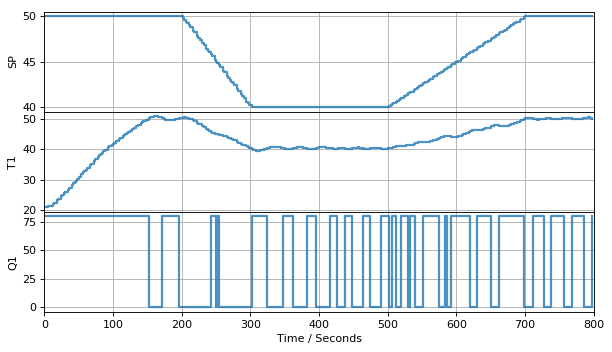

TCLab Model disconnected successfully.


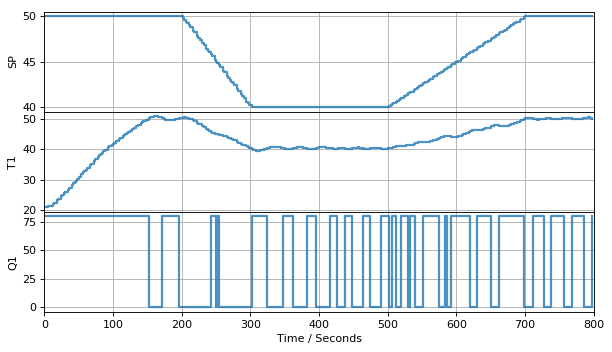

In [11]:
from tclab import setup, clock, Historian, Plotter
TCLab = setup(connected=False, speedup=20)

# create a controller instance
controller = relay(0, 80)
controller.send(None)

# execute the event loop
tf = 800
with TCLab() as lab:
    h = Historian([('SP', lambda: Tsp(t)), ('T1', lambda: lab.T1), ('Q1', lab.Q1)])
    p = Plotter(h, tf)
    for t in clock(tf, 2):
        T1 = lab.T1                      # take measurement
        SP = Tsp(t)                      # get setpoint
        U1 = controller.send([SP, T1])   # compute control action
        lab.U1 = U1                      # set manipulated variable  
        p.update(t)                      # log data

## Linear Estimation

The trouble with the relay control is that it is measuring the sensor temperaturre, not the heater temperature which is what we would like to control. Because of the time lag between a change in heater temperature and sensor when it is detected by the sensor, we may not be doing as good of a job controlling the heater as we might think.

To do better, we have to find a way of embedding our knowledge of the dynamic response of this system into the feedback control.

### Model Response to a 50% power input

As a first step, let's recall the two state model that was previously developed for the heater/sensor system. This cell creates a plot of the predicted heater and sensor temperature corresponding to a power setting of 50%.

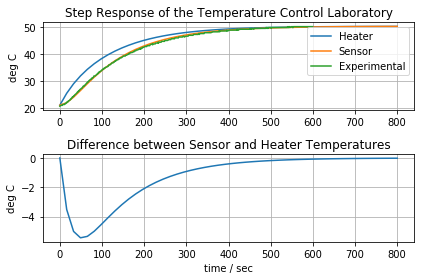

In [34]:
# parameter estimates
U = 50                # power input
P =  0.04             # power input when the system is turned
Ua = 0.068            # heat transfer coefficient from heater to environment
CpH = 6.50            # heat capacity of the heater (J/deg C)
CpS = 1.25            # heat capacity of the sensor (J/deg C)
Uc = 0.036            # heat transfer coefficient from heater to sensor
Tamb = 21             # ambient room temperature

# state space model
A = [[-(Ua + Uc)/CpH, Uc/CpH], [Uc/CpS, -Uc/CpS]]
B = [[P/CpH], [0]] # single column
C = [[0, 1]]   # single row
D = [[0]]

# create the state space model object
ss= control.StateSpace(A, B, C, D)

# perform the step response simulation returning vectors with time and output
t = np.linspace(0, 800)
t, y, x = control.step_response(ss, t, [0,0], return_x = True)

Th = U*x[0] + Tamb
Ts = U*x[1] + Tamb

# Get experimental results
df = pd.read_csv('step01.csv')

# plot the results
plt.subplot(2,1,1)
plt.plot(t, Th, t, Ts)
plt.plot(df['Time'], df['T1'])
plt.ylabel('deg C')
plt.title('Step Response of the Temperature Control Laboratory')
plt.legend(['Heater', 'Sensor', 'Experimental'])
plt.grid(True)

plt.subplot(2,1,2)
plt.ylabel('deg C')
plt.xlabel('time / sec')
plt.title('Difference between Sensor and Heater Temperatures')
plt.plot(t, Ts - Th)
plt.grid(True)
plt.tight_layout()

### Embedding the Model into a Python Generator

In [6]:
import numpy as np
import control 

def tclab():
    # parameter estimates
    P =  0.04             # power input when the system is turned
    Ua = 0.068            # heat transfer coefficient from heater to environment
    CpH = 6.50            # heat capacity of the heater (J/deg C)
    CpS = 1.25            # heat capacity of the sensor (J/deg C)
    Uc = 0.036            # heat transfer coefficient from heater to sensor
    Tamb = 21             # ambient room temperature

    # state space model
    A = [[-(Ua + Uc)/CpH, Uc/CpH], [Uc/CpS, -Uc/CpS]]
    B = [[P/CpH], [0]] # single column
    C = [[0, 1]]   # single row
    D = [[0]]

    # create the state space model object
    ss= control.StateSpace(A, B, C, D)

    # initialize variables that will be updated in time
    t = 0
    x = [0, 0]
    
    while True:
        # yield the heater temperature to the calling program
        Th = x[0] + Tamb
        Ts = x[1] + Tamb
        tnext, Q, T1 = yield Th, Ts
        _, _, xpred = control.forced_response(ss, [t, tnext], [Q, Q], x, transpose=True)
        t = tnext
        x = xpred[-1]

### Open Loop Estimation

For this first case, we'll simply use the heater temperature predicted by the model for control. We'll record the measured sensor temperature, but that value will be otherwise ignored in estimator and control calculations.

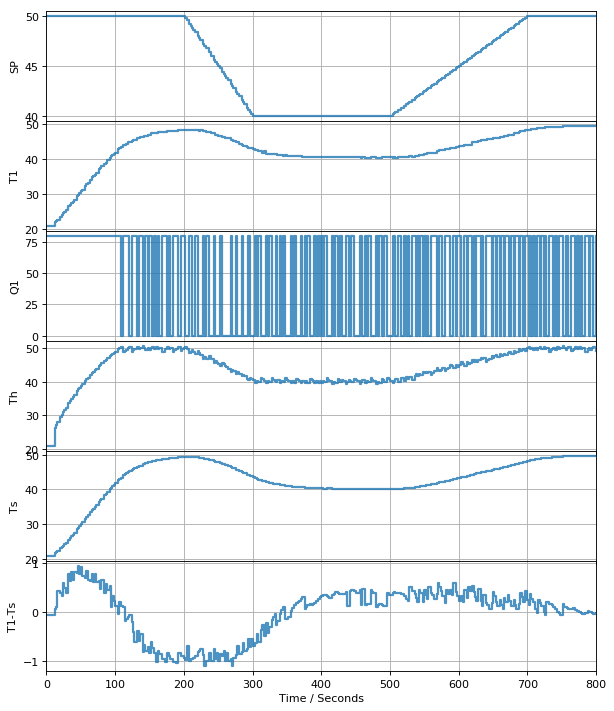

TCLab Model disconnected successfully.


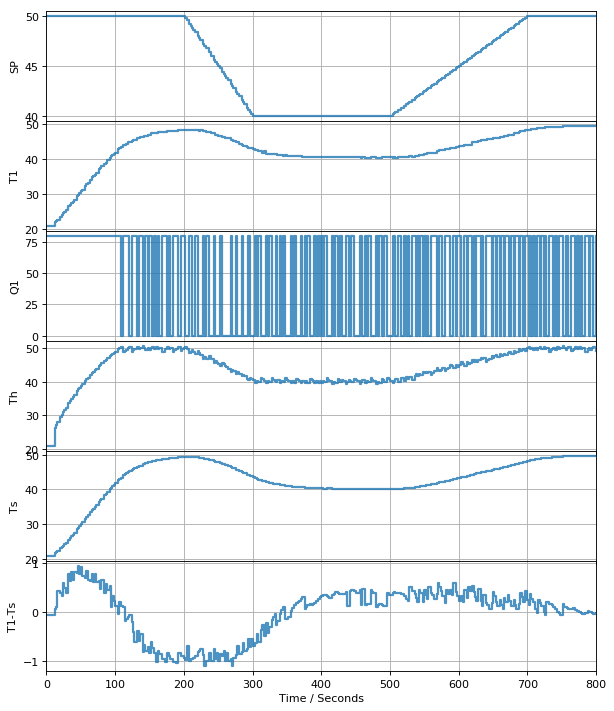

In [7]:
from tclab import setup, clock, Historian, Plotter
TCLab = setup(connected=False, speedup=20)

tf = 800        # run time

# create a controller instance
controller = relay(0, 80)
controller.send(None)

# create an model estimator
estimator = tclab()
estimator.send(None)

# execute the event loop
tf = 800
with TCLab() as lab:
    h = Historian([('SP', lambda: Tsp(t)), ('T1', lambda: lab.T1), ('Q1', lab.Q1),
                   ('Th', lambda: Th), ('Ts', lambda: Ts), ('T1-Ts', lambda: T1-Ts)])
    p = Plotter(h, tf)
    U1 = 0
    for t in clock(tf, 2):                    # allow time for more calculations
        T1 = lab.T1                           # measure the sensor temperature
        Th, Ts = estimator.send([t, U1, T1])  # estimate the heater temperature
        SP = Tsp(t)                           # get setpoint
        U1 = controller.send([SP, Th])        # compute control action
        lab.U1 = U1                           # set manipulated variable  
        p.update(t)                           # log data

## Speeding Things Up

In [10]:
import numpy as np
import control 

def tclab():
    # parameter estimates
    P =  0.04             # power input when the system is turned
    Ua = 0.068            # heat transfer coefficient from heater to environment
    CpH = 6.50            # heat capacity of the heater (J/deg C)
    CpS = 1.25            # heat capacity of the sensor (J/deg C)
    Uc = 0.036            # heat transfer coefficient from heater to sensor
    Tamb = 21             # ambient room temperature

    # state space model
    A = [[-(Ua + Uc)/CpH, Uc/CpH], [Uc/CpS, -Uc/CpS]]
    B = [[P/CpH], [0]] # single column
    C = [[0, 1]]   # single row
    D = [[0]]

    # initialize variables that will be updated in time
    t = 0
    x = np.array([0, 0])
    
    while True:
        # yield the heater temperature to the calling program
        Th = x[0] + Tamb
        Ts = x[1] + Tamb
        tnext, Q, T1 = yield Th, Ts
        dt = tnext - t
        x = x + dt*np.dot(A, x) + dt*np.dot(B, [Q])
        t = tnext

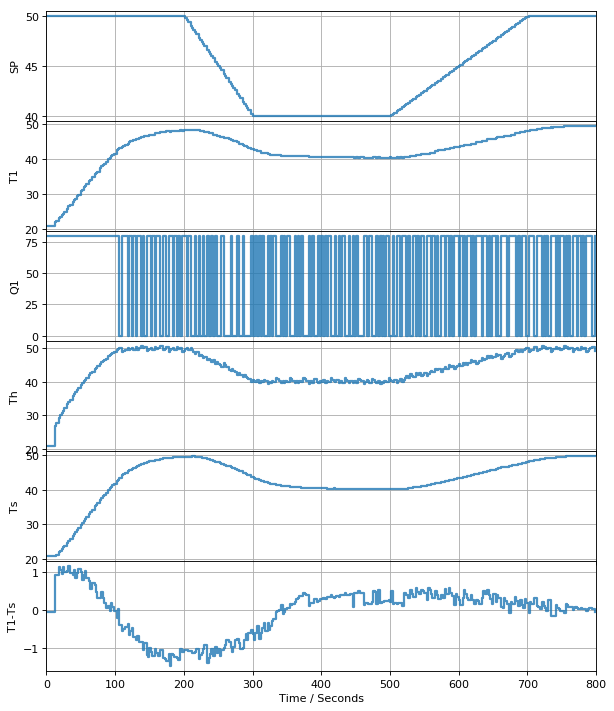

TCLab Model disconnected successfully.


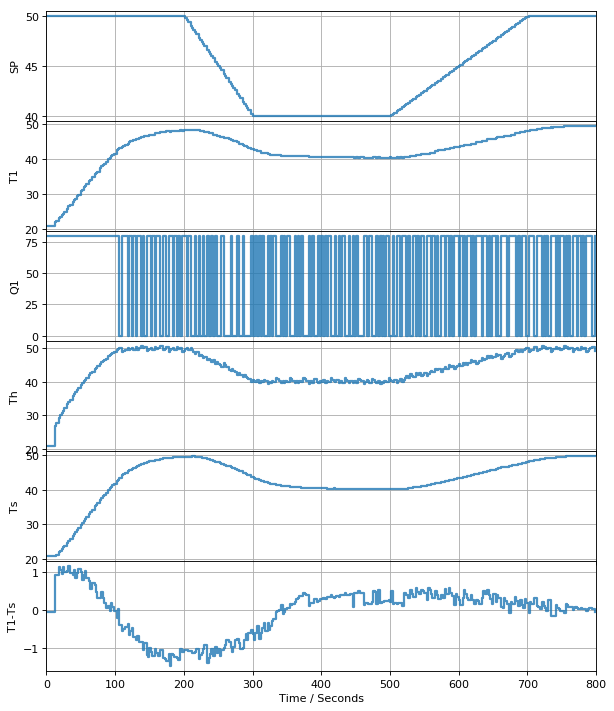

In [11]:
from tclab import setup, clock, Historian, Plotter
TCLab = setup(connected=False, speedup=20)

tf = 800        # run time

# create a controller instance
controller = relay(0, 80)
controller.send(None)

# create an model estimator
estimator = tclab()
estimator.send(None)

# execute the event loop
tf = 800
with TCLab() as lab:
    h = Historian([('SP', lambda: Tsp(t)), ('T1', lambda: lab.T1), ('Q1', lab.Q1),
                   ('Th', lambda: Th), ('Ts', lambda: Ts), ('T1-Ts', lambda: T1-Ts)])
    p = Plotter(h, tf)
    U1 = 0
    for t in clock(tf, 2):                    # allow time for more calculations
        T1 = lab.T1                           # measure the sensor temperature
        Th, Ts = estimator.send([t, U1, T1])  # estimate the heater temperature
        SP = Tsp(t)                           # get setpoint
        U1 = controller.send([SP, Th])        # compute control action
        lab.U1 = U1                           # set manipulated variable  
        p.update(t)                           # log data

In [13]:
# parameter estimates
P =  0.04             # power input when the system is turned
Ua = 0.068            # heat transfer coefficient from heater to environment
CpH = 6.50            # heat capacity of the heater (J/deg C)
CpS = 1.25            # heat capacity of the sensor (J/deg C)
Uc = 0.036            # heat transfer coefficient from heater to sensor
Tamb = 21             # ambient room temperature

# state space model
A = [[-(Ua + Uc)/CpH, Uc/CpH], [Uc/CpS, -Uc/CpS]]
B = [[P/CpH], [0]] # single column
C = [[0, 1]]   # single row
D = [[0]]


In [19]:
import numpy as np

lambdas, vecs = np.linalg.eig(A)
-1/lambdas

array([121.33951135,  27.35329911])

## Closed Loop Estimation

Examining the results, we see the predicted heater temperature appears to track the desired setpoint, but the sensor temperature is off the mark. This could be due several factors, most likely model error.

Process
\begin{align*}
\frac{dx}{dt} & = A x + B u \\
y & = C x + D u
\end{align*}

Model
\begin{align*}
\frac{d\hat{x}}{dt} & = A \hat{x} + B u \\
\hat{y} & = C \hat{x} + D u
\end{align*}

If the measured and estimated outputs are different, then $y - \hat{y} \neq 0$. Taking the difference we find

\begin{align*}
y - \hat{y} & = C x + Du - C\hat{x} - Du \\
& = C(x - \hat{x})
\end{align*}

The difference $y - \hat{y}$ can be observed.  But what we want is to make $x - \hat{x}$ small. Is there way to use knowledge of $y - \hat{y}$ to reduce $x - \hat{x}$?

The technique is to introduce feedback $L(y-\hat{y})$ to the model.  

\begin{align*}
\frac{d\hat{x}}{dt} & = A \hat{x} + B u + L(y - \hat{y}) \\
\hat{y} & = C \hat{x} + D u
\end{align*}

Subtracting the new model equations from the process model, we get an expression for the dynamics of the model error $e = x - \hat{x]$

\begin{align*}
\frac{de}{dt} & = \frac{dx}{dt} - \frac{d\hat{x}}{dt} \\
\\
& = (Ax + Bu) - (A\hat{x} + Bu + L(Cx - C\hat{x})) \\
\\
& = (A - LC)(x -\hat{x}) \\
\\
\frac{de}{dt} & = (A - LC) e
\end{align*}

In [77]:
L = np.array([[1],[.4]])

Aobs = A - np.dot(L,C)
evals, evecs = np.linalg.eig(Aobs)
1/evals

array([-9.59273314, -2.93638823])

In [10]:
import numpy as np
import control 

def tclab():
    # parameter estimates
    P =  0.04             # power input when the system is turned
    Ua = 0.068            # heat transfer coefficient from heater to environment
    CpH = 6.50            # heat capacity of the heater (J/deg C)
    CpS = 1.25            # heat capacity of the sensor (J/deg C)
    Uc = 0.036            # heat transfer coefficient from heater to sensor
    Tamb = 21             # ambient room temperature

    # state space model
    A = [[-(Ua + Uc)/CpH, Uc/CpH], [Uc/CpS, -Uc/CpS]]
    B = [[P/CpH], [0]] # single column
    C = [[0, 1]]   # single row
    D = [[0]]

    # initialize variables that will be updated in time
    t = 0
    x = np.array([0, 0])
    
    # observer gain
    L = [[1], [0.4]]
    
    while True:
        # yield the heater temperature to the calling program
        Th = x[0] + Tamb
        Ts = x[1] + Tamb
        tnext, Q, T1 = yield Th, Ts
        dt = tnext - t
        x = x + dt*np.dot(A, x) + dt*np.dot(B, [Q]) + dt*np.dot(L, [T1-Ts])
        t = tnext

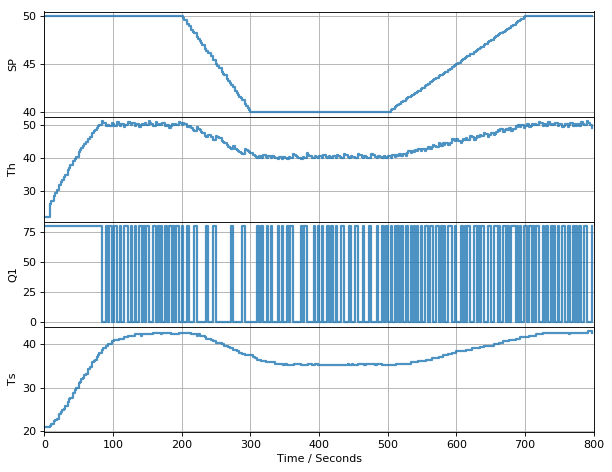

TCLab Model disconnected successfully.


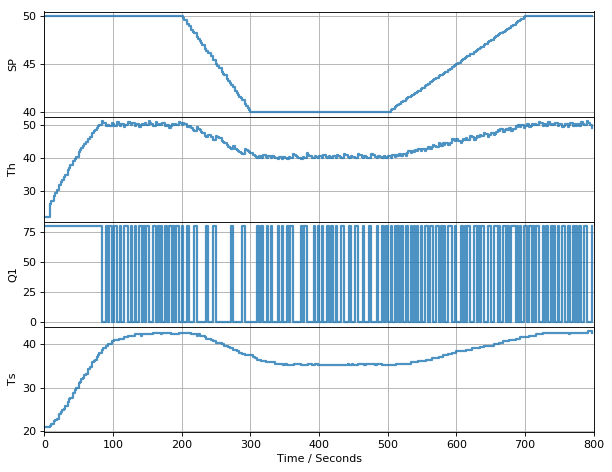

In [11]:
from tclab import setup, clock, Historian, Plotter
TCLab = setup(connected=False, speedup=20)

tf = 800        # run time

# create a controller instance
controller = relay(0, 80)
controller.send(None)

# create an model estimator
estimator = tclab()
estimator.send(None)

# execute the event loop
tf = 800
with TCLab() as lab:
    h = Historian([('SP', lambda: Tsp(t)), ('Th', lambda: Th), ('Q1', lab.Q1), ('Ts', lambda: lab.T1)])
    p = Plotter(h, tf)
    U1 = 0
    for t in clock(tf, 2):                # use a time step of 2 to allow time for more calculations
        Ts = lab.T1                       # take measurement
        SP = Tsp(t)                       # get setpoint
        Th = estimator.send([t, U1, Ts])  # get 
        U1 = controller.send([SP, Th])    # compute control action
        lab.U1 = U1                       # set manipulated variable  
        p.update(t)                       # log data

## Exercises

1. Implement the Temperature Setpoint using a Python generator.